In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Volvo.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_740,Seri_850,Seri_940,...,Model_2.8 T6,Model_2.9 T6 Executive,Model_3.0,Model_GL TD,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,650000,2013,115,1560,272000,7.0,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1038000,2016,152,1498,77000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,209900,1997,180,1984,287000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,699000,2012,180,1595,208000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,425000,2009,109,1560,213000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_4056\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,225719.843633,2.573718e+10,160428.128172,93342.920313


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:26:28,127] A new study created in memory with name: no-name-683d711d-d574-4ea6-94cc-5f0aa60b7c1e
[I 2023-10-08 14:26:28,254] Trial 0 finished with value: 980321.7091173608 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0019887767806492746, 'max_depth': 6, 'min_child_weight': 124}. Best is trial 0 with value: 980321.7091173608.
[I 2023-10-08 14:26:28,254] Trial 1 finished with value: 813038.7070676752 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.045896235312676684, 'max_depth': 3, 'min_child_weight': 195}. Best is trial 1 with value: 813038.7070676752.
[I 2023-10-08 14:26:28,276] Trial 2 finished with value: 990669.9149602156 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.0015070217335934584, 'max_depth': 10, 'min_child_weight': 242}. Best is trial 1 with value: 813038.7070676752.
[I 2023-10-08 14:26:28,293] Trial 5 finished with value: 989087.666047265 and parameters: {'co

[I 2023-10-08 14:26:29,268] Trial 30 finished with value: 581958.5602118997 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.07008157474911686, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 17 with value: 262528.73219612346.
[I 2023-10-08 14:26:29,289] Trial 31 finished with value: 878614.0008388893 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014431851696790827, 'max_depth': 8, 'min_child_weight': 3}. Best is trial 17 with value: 262528.73219612346.
[I 2023-10-08 14:26:29,384] Trial 32 finished with value: 337256.55138819024 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.48314497430885783, 'max_depth': 15, 'min_child_weight': 38}. Best is trial 17 with value: 262528.73219612346.
[I 2023-10-08 14:26:29,406] Trial 33 finished with value: 394974.4632250167 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2567526452340474, 'max_depth': 15, 'min_child_weigh

[I 2023-10-08 14:26:30,697] Trial 61 finished with value: 440407.0319937083 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.20803174362733357, 'max_depth': 3, 'min_child_weight': 59}. Best is trial 46 with value: 228532.644558273.
[I 2023-10-08 14:26:30,727] Trial 62 finished with value: 461549.3231558364 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.1844025367657645, 'max_depth': 3, 'min_child_weight': 60}. Best is trial 46 with value: 228532.644558273.
[I 2023-10-08 14:26:30,728] Trial 60 finished with value: 448064.7727579192 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.19906411464361987, 'max_depth': 3, 'min_child_weight': 62}. Best is trial 46 with value: 228532.644558273.
[I 2023-10-08 14:26:30,730] Trial 63 finished with value: 519008.75757183664 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.19271015860064708, 'max_depth': 3, 'min_child_weight': 101}

[I 2023-10-08 14:26:32,178] Trial 91 finished with value: 206741.72168963484 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.24593593185468007, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 76 with value: 188220.5813580198.
[I 2023-10-08 14:26:32,195] Trial 90 finished with value: 213074.90325450886 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.24708432293083413, 'max_depth': 13, 'min_child_weight': 2}. Best is trial 76 with value: 188220.5813580198.
[I 2023-10-08 14:26:32,254] Trial 92 finished with value: 187816.04535949117 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2762014227320953, 'max_depth': 12, 'min_child_weight': 6}. Best is trial 92 with value: 187816.04535949117.
[I 2023-10-08 14:26:32,315] Trial 94 finished with value: 174177.75141938502 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.27072116876574526, 'max_depth': 12, 'min_child_weigh

[I 2023-10-08 14:26:33,754] Trial 120 finished with value: 167600.50640590506 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.36786925102251467, 'max_depth': 11, 'min_child_weight': 7}. Best is trial 120 with value: 167600.50640590506.
[I 2023-10-08 14:26:33,806] Trial 121 finished with value: 177386.74275131282 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4026092575967808, 'max_depth': 11, 'min_child_weight': 7}. Best is trial 120 with value: 167600.50640590506.
[I 2023-10-08 14:26:33,871] Trial 122 finished with value: 276764.7535929782 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.40075407440570965, 'max_depth': 11, 'min_child_weight': 33}. Best is trial 120 with value: 167600.50640590506.
[I 2023-10-08 14:26:33,935] Trial 123 finished with value: 366344.9596692936 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.12219831003903188, 'max_depth': 11, 'min_chi

[I 2023-10-08 14:26:35,501] Trial 150 finished with value: 149182.8514069572 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3494053165009598, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 150 with value: 149182.8514069572.
[I 2023-10-08 14:26:35,536] Trial 151 finished with value: 198040.66897353073 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.310694892409255, 'max_depth': 11, 'min_child_weight': 6}. Best is trial 150 with value: 149182.8514069572.
[I 2023-10-08 14:26:35,593] Trial 152 finished with value: 990669.9149602156 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3275763193817436, 'max_depth': 11, 'min_child_weight': 256}. Best is trial 150 with value: 149182.8514069572.
[I 2023-10-08 14:26:35,664] Trial 153 finished with value: 163451.39743404672 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.32319662064501387, 'max_depth': 11, 'min_child_we

[I 2023-10-08 14:26:37,301] Trial 180 finished with value: 168216.03179430694 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.49727379438746, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 167 with value: 133326.99865339644.
[I 2023-10-08 14:26:37,459] Trial 181 finished with value: 660171.9390718552 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4698980184619722, 'max_depth': 11, 'min_child_weight': 139}. Best is trial 167 with value: 133326.99865339644.
[I 2023-10-08 14:26:37,510] Trial 183 finished with value: 752424.060027409 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.03234332535688151, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 167 with value: 133326.99865339644.
[I 2023-10-08 14:26:37,510] Trial 182 finished with value: 126903.67950453167 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4921283301862097, 'max_depth': 11, 'min_child_w

[I 2023-10-08 14:26:39,183] Trial 210 finished with value: 225055.4930445198 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.49417366040860905, 'max_depth': 10, 'min_child_weight': 12}. Best is trial 182 with value: 126903.67950453167.
[I 2023-10-08 14:26:39,278] Trial 211 finished with value: 153525.9423625616 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.49572477495787787, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 182 with value: 126903.67950453167.
[I 2023-10-08 14:26:39,327] Trial 212 finished with value: 156592.53159066103 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4992314652312839, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 182 with value: 126903.67950453167.
[I 2023-10-08 14:26:39,416] Trial 213 finished with value: 217910.07637827192 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4810094303675254, 'max_depth': 10, 'min_chil

[I 2023-10-08 14:26:41,233] Trial 239 finished with value: 205617.84028906553 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.49977929863908144, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 235 with value: 124178.34895001478.
[I 2023-10-08 14:26:41,255] Trial 241 finished with value: 203302.06302377608 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4969251848433285, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 235 with value: 124178.34895001478.
[I 2023-10-08 14:26:41,322] Trial 242 finished with value: 509481.4693979901 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.08154351305395227, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 235 with value: 124178.34895001478.
[I 2023-10-08 14:26:41,449] Trial 243 finished with value: 210544.16999050495 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.31450094385626537, 'max_depth': 10, 'min_chi

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 124178.3490
Best params:
	colsample_bytree: 0.8
	subsample: 0.6
	learning_rate: 0.41166256867444134
	max_depth: 10
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 240252.9135850296, 'MSE': 13207704363.901577, 'RMSE': 114924.77697999495, 'MAE': 83168.31899038462}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9696452200341843

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9564285455036138

In [16]:
marka_model = joblib.dump(final_model, "Volvo.pkl")

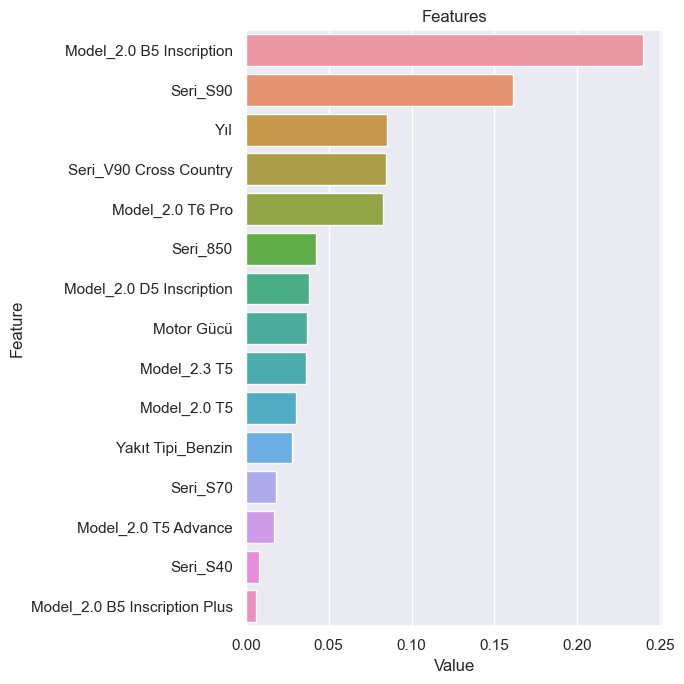

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)